<a href="https://colab.research.google.com/github/HareeshVutla/Deeplearning/blob/main/Image_classification_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
import numpy as np
import tensorflow as tf
import os
import PIL
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Download the flowers dataset

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 1s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


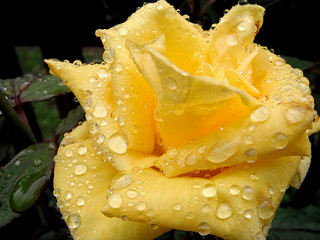

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))


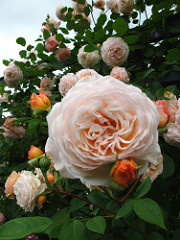

In [8]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

# **Load data using Keras utility**

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# **Visualize the data**

In [13]:
import matplotlib.pyplot as plt

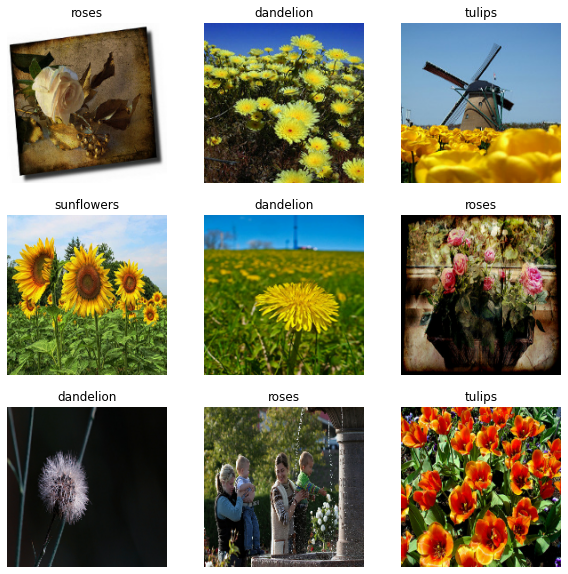

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


# **Standardize the data**

In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [20]:
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
print("image size:",first_image.shape)
print("classes/labels size: ",labels_batch.shape)

0.0 1.0
image size: (180, 180, 3)
classes/labels size:  (32,)


In [21]:
AUTOTUNE = tf.data.AUTOTUNE


# **Configure the dataset**

# **.cache():**
keeps the images in memory after they're loaded off disk during the first epoch.

This will ensure the dataset does not become a bottleneck while training your model

# **.Prefetch():**
overlaps data preprocessing and model execution while training.

In [22]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Model Training**

In [23]:
num_classes = 5
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [24]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [81]:
epochs = 5

In [77]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
92/92 [==============================] - 114s 1s/step - loss: 0.1310 - accuracy: 0.9595 - val_loss: 0.7347 - val_accuracy: 0.7670
Epoch 2/5
92/92 [==============================] - 108s 1s/step - loss: 0.0861 - accuracy: 0.9721 - val_loss: 1.0024 - val_accuracy: 0.7466
Epoch 3/5
92/92 [==============================] - 108s 1s/step - loss: 0.0494 - accuracy: 0.9881 - val_loss: 0.9366 - val_accuracy: 0.7534
Epoch 4/5
92/92 [==============================] - 108s 1s/step - loss: 0.1131 - accuracy: 0.9649 - val_loss: 0.9915 - val_accuracy: 0.7425
Epoch 5/5
92/92 [==============================] - 107s 1s/step - loss: 0.0581 - accuracy: 0.9830 - val_loss: 1.0287 - val_accuracy: 0.7561


In [ ]:
print()

In [78]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

# **Visualize the training results**

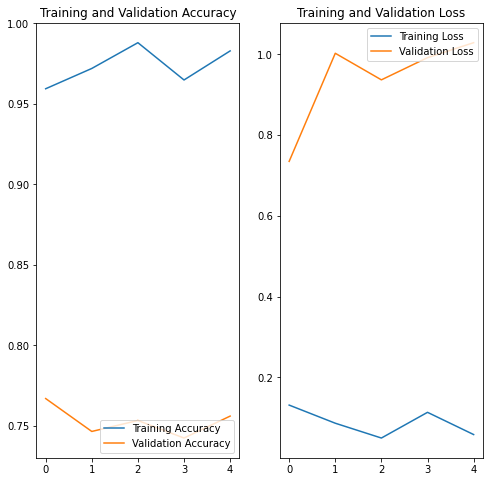

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
img_pred = model.predict(val_ds)

3


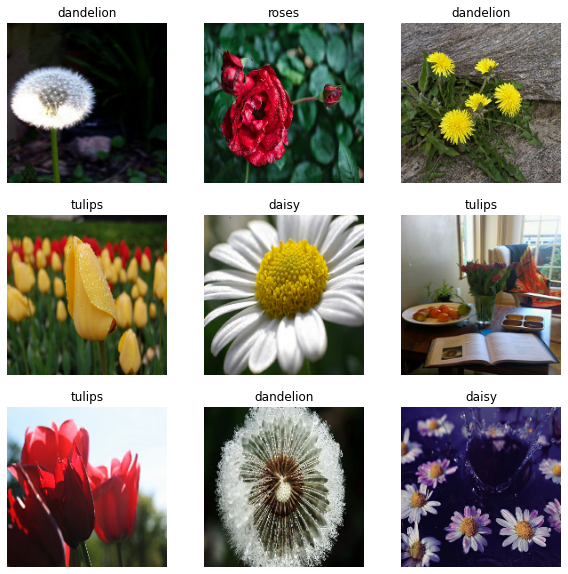

In [72]:
print(np.argmax(img_pred[3]))

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [64]:
img_pred_classes = [np.argmax(index) for index in img_pred]

print(img_pred_classes)

[2, 1, 1, 3, 4, 3, 1, 3, 2, 2, 1, 0, 3, 4, 4, 2, 2, 1, 3, 4, 1, 4, 1, 3, 4, 4, 1, 3, 4, 3, 1, 2, 4, 1, 1, 4, 4, 0, 1, 4, 0, 0, 2, 4, 2, 0, 1, 1, 2, 1, 0, 4, 0, 0, 4, 0, 4, 0, 4, 0, 2, 1, 1, 1, 3, 2, 3, 2, 3, 1, 4, 1, 4, 3, 0, 0, 3, 1, 1, 4, 0, 2, 3, 4, 1, 3, 4, 1, 1, 2, 3, 2, 3, 2, 4, 1, 4, 4, 2, 0, 0, 0, 4, 3, 0, 2, 0, 0, 3, 4, 2, 2, 4, 3, 1, 1, 0, 1, 0, 3, 1, 3, 3, 1, 0, 3, 0, 0, 2, 3, 3, 1, 0, 2, 1, 1, 3, 4, 3, 2, 2, 1, 4, 0, 3, 1, 3, 3, 1, 4, 2, 2, 1, 1, 1, 4, 0, 0, 2, 3, 0, 2, 1, 4, 2, 4, 2, 0, 3, 0, 2, 3, 2, 2, 3, 4, 1, 1, 1, 2, 0, 0, 2, 0, 4, 2, 0, 2, 0, 4, 0, 1, 3, 0, 3, 0, 1, 3, 2, 2, 0, 0, 1, 4, 0, 1, 1, 0, 4, 2, 1, 0, 1, 1, 3, 0, 2, 2, 3, 4, 1, 2, 1, 0, 1, 4, 1, 3, 4, 0, 4, 4, 2, 1, 1, 0, 0, 1, 1, 3, 0, 0, 1, 1, 1, 3, 1, 1, 0, 4, 3, 1, 2, 3, 1, 0, 3, 1, 4, 0, 0, 4, 3, 1, 4, 1, 2, 4, 4, 2, 2, 2, 0, 3, 3, 0, 1, 4, 4, 0, 3, 2, 3, 1, 0, 0, 3, 2, 1, 0, 1, 4, 2, 0, 1, 1, 1, 3, 4, 4, 1, 0, 3, 3, 3, 1, 3, 1, 1, 2, 1, 1, 3, 4, 0, 2, 0, 0, 0, 1, 3, 2, 1, 2, 4, 1, 4, 1, 3, 2, 1, 0, 1, 

# **Manual Input Data pipelines using tf.data**

In [32]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/tulips/16506668270_b823935dc3.jpg'
b'/root/.keras/datasets/flower_photos/daisy/11023214096_b5b39fab08.jpg'
b'/root/.keras/datasets/flower_photos/roses/6105809987_8f3d7a8d67_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/3761310831_41b5eba622_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/3704306975_75b74497d8.jpg'


In [33]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)


['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [36]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
print("Training data samples:",tf.data.experimental.cardinality(train_ds).numpy())
print("Validation data samples:",tf.data.experimental.cardinality(val_ds).numpy())

Training data samples: 2936
Validation data samples: 734


a short function that converts a file path to an (img, label) pair:

In [37]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [38]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [39]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [40]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [41]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  4


In [42]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

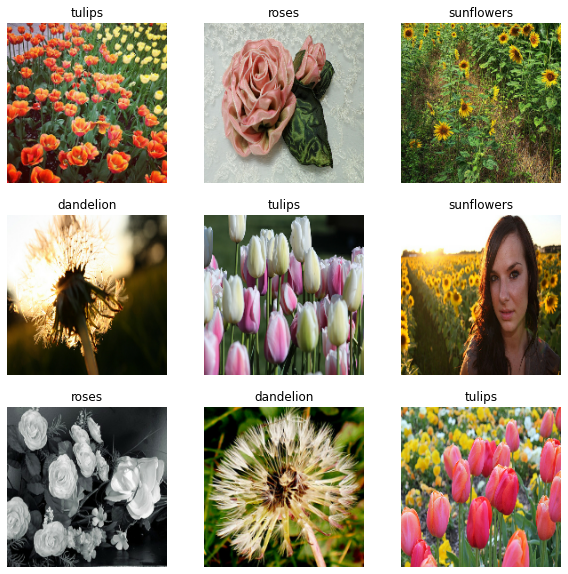

In [43]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [83]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 110s 1s/step - loss: 0.0348 - accuracy: 0.9898 - val_loss: 1.0479 - val_accuracy: 0.7520
Epoch 2/3
92/92 [==============================] - 109s 1s/step - loss: 0.0126 - accuracy: 0.9973 - val_loss: 1.2505 - val_accuracy: 0.7439
Epoch 3/3
92/92 [==============================] - 138s 2s/step - loss: 0.0090 - accuracy: 0.9983 - val_loss: 1.2702 - val_accuracy: 0.7548


In [86]:
epochs = 3

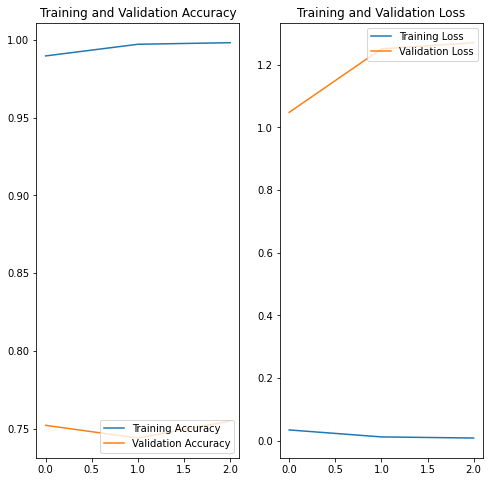

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Overfittting**

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

# **Data augmentation and  Dropout**

## **Data augmentation**
Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [84]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

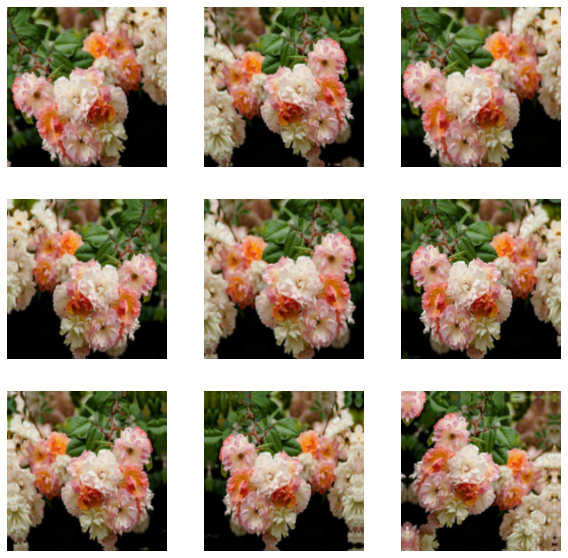

In [88]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# **Drop Out**

Another technique to reduce overfitting is to introduce dropout regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

# **Model**

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# **Compile and train the model**

In [91]:
 model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [92]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

In [93]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 133s 1s/step - loss: 0.0362 - accuracy: 0.9905 - val_loss: 1.6054 - val_accuracy: 0.7248
Epoch 2/15
92/92 [==============================] - 141s 2s/step - loss: 0.0315 - accuracy: 0.9898 - val_loss: 1.3115 - val_accuracy: 0.7411
Epoch 3/15
92/92 [==============================] - 120s 1s/step - loss: 0.0318 - accuracy: 0.9911 - val_loss: 1.4685 - val_accuracy: 0.7098
Epoch 4/15
92/92 [==============================] - 109s 1s/step - loss: 0.0336 - accuracy: 0.9922 - val_loss: 1.8644 - val_accuracy: 0.6907
Epoch 5/15
92/92 [==============================] - 125s 1s/step - loss: 0.0263 - accuracy: 0.9928 - val_loss: 1.6406 - val_accuracy: 0.7044
Epoch 6/15
92/92 [==============================] - 108s 1s/step - loss: 0.0474 - accuracy: 0.9840 - val_loss: 2.1822 - val_accuracy: 0.6717
Epoch 7/15
92/92 [==============================] - 108s 1s/step - loss: 0.0393 - accuracy: 0.9871 - val_loss: 1.7123 - val_accuracy: 0.7003
Epoch 8/15
92

# **Visualize training results**

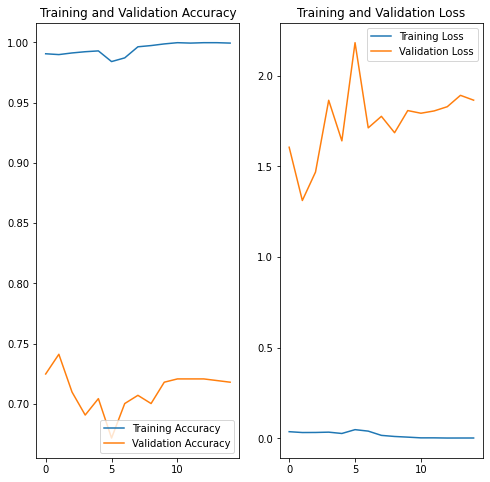

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Predict on new data**

In [105]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

In [107]:
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

In [108]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 69.22 percent confidence.
